Bryan Jay - 260738764

## 1 - Data Acquisition


In [ ]:
import cv2
import numpy as np 
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

group_img = cv2.imread('./images/group2.jpg')
# group_img = cv2.resize(group_img, None, fx=0.3, fy=0.3)
# display images
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(cv2.cvtColor(group_img, cv2.COLOR_BGR2RGB))
plt.title("Group Image"), plt.xticks([]), plt.yticks([])
plt.show()
img = group_img.copy()
print(group_img.shape)

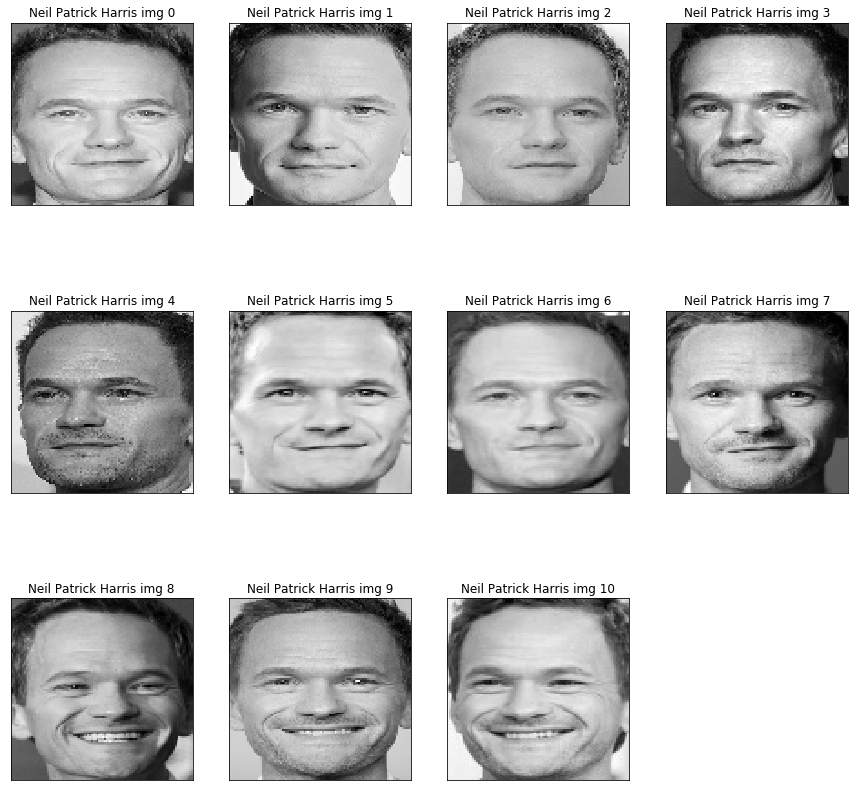

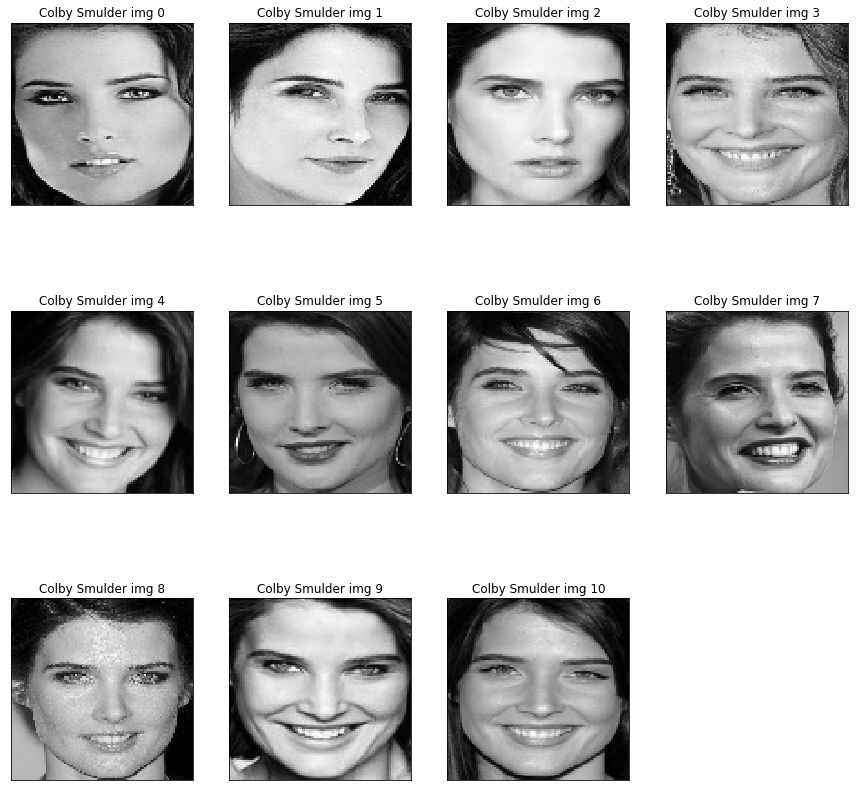

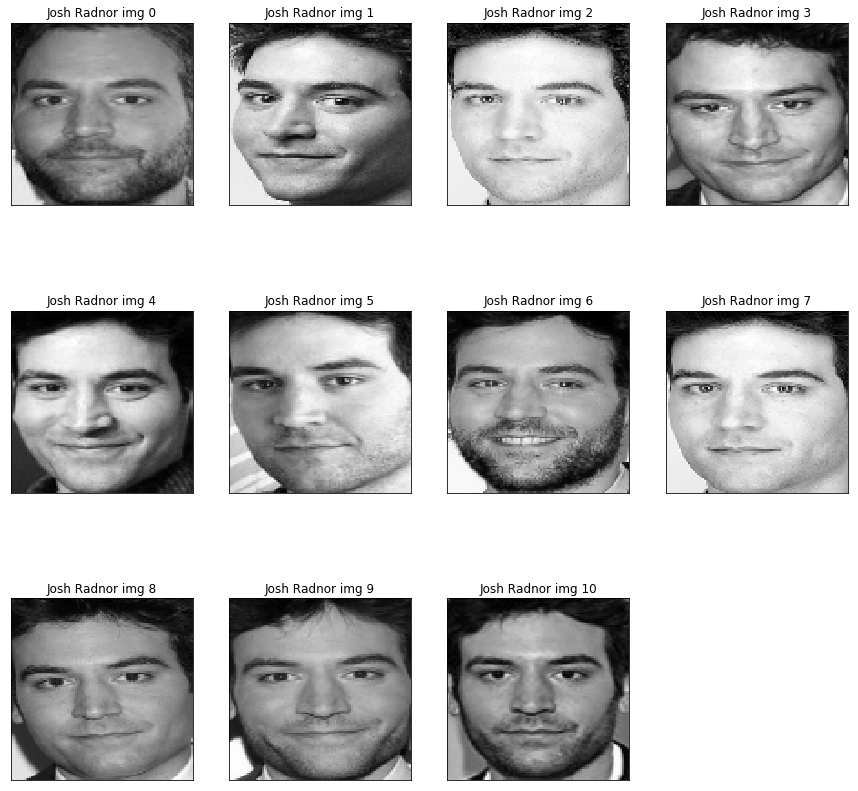

In [2]:
nph_img = []
cs_img = []
tm_img = []

size = (100,100)
for i in range(11):
    path = './images/{title}{index}.jpg'

    nph_resized = cv2.resize(cv2.imread(path.format(title='nph', index=i)), size)
    nph_img.append(cv2.cvtColor(nph_resized, cv2.COLOR_BGR2GRAY))
    
    cs_resized = cv2.resize(cv2.imread(path.format(title='cs', index=i)), size)
    cs_img.append(cv2.cvtColor(cs_resized, cv2.COLOR_BGR2GRAY))
    
    tm_resized = cv2.resize(cv2.imread(path.format(title='tm', index=i)), size)
    tm_img.append(cv2.cvtColor(tm_resized, cv2.COLOR_BGR2GRAY))

plt.figure(figsize=(15,15))
for i in range(11):
    plt.subplot(3,4,1+i), plt.imshow(nph_img[i], cmap='gray')
    plt.title("Neil Patrick Harris img " + str(i)), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
for i in range(11):
    plt.subplot(3,4,1+i), plt.imshow(cs_img[i], cmap='gray')
    plt.title("Colby Smulder img " + str(i)), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
for i in range(11):
    plt.subplot(3,4,1+i), plt.imshow(tm_img[i], cmap='gray')
    plt.title("Josh Radnor img " + str(i)), plt.xticks([]), plt.yticks([])
plt.show()

I selected the group photo based on several factors we discussed in the notes. In the group photo all the people were looking towards the camera with a relativerly straight viewpoint, the lighting was good for all the faces, there was not any occlusion. Additionally the background is white with a little bit of writting which is not causing too much noise so there is the faces are easier to distinguish from between the background and the lighter faces of the 3 people.

In order to chose the 33 images, I looked for images where the celeb had good lighting and the face was easy to see in the background. The group of images have different features in them, since i took some rotated differently, some with teeth showing and with the head slightly rotated as well. All the images are resized to (100,100) so that M = 10,000

## 2 - Eigenvector Representation

In [3]:
# create the vector for each image, for the image
nph_vec = [np.reshape(nph_img[i], (nph_img[i].shape[0]*nph_img[i].shape[1],-1)) for i in range(len(nph_img))]
cs_vec = [np.reshape(cs_img[i], (cs_img[i].shape[0]*cs_img[i].shape[1],-1)) for i in range(len(cs_img))]
tm_vec = [np.reshape(tm_img[i], (tm_img[i].shape[0]*tm_img[i].shape[1],-1)) for i in range(len(tm_img))]

# put all the vectors into single array where each cell contains the image
nph_arr = np.hstack((nph_vec))
cs_arr = np.hstack((cs_vec))
tm_arr = np.hstack((tm_vec))

D = np.hstack((nph_arr, cs_arr, tm_arr))

In [4]:
# method from notes
# mean_D = D.mean(axis=0)
# D = D - mean_D
# # find the variance of the data
# # get N 
# N = D.shape[1]
# # get the variances
# var = [(1/(N-1)) * np.dot(np.dot(v.transpose(), np.dot(D, np.transpose(D))), v) for v in D.transpose()]

# print(var)

(33, 10000)
(100, 100)


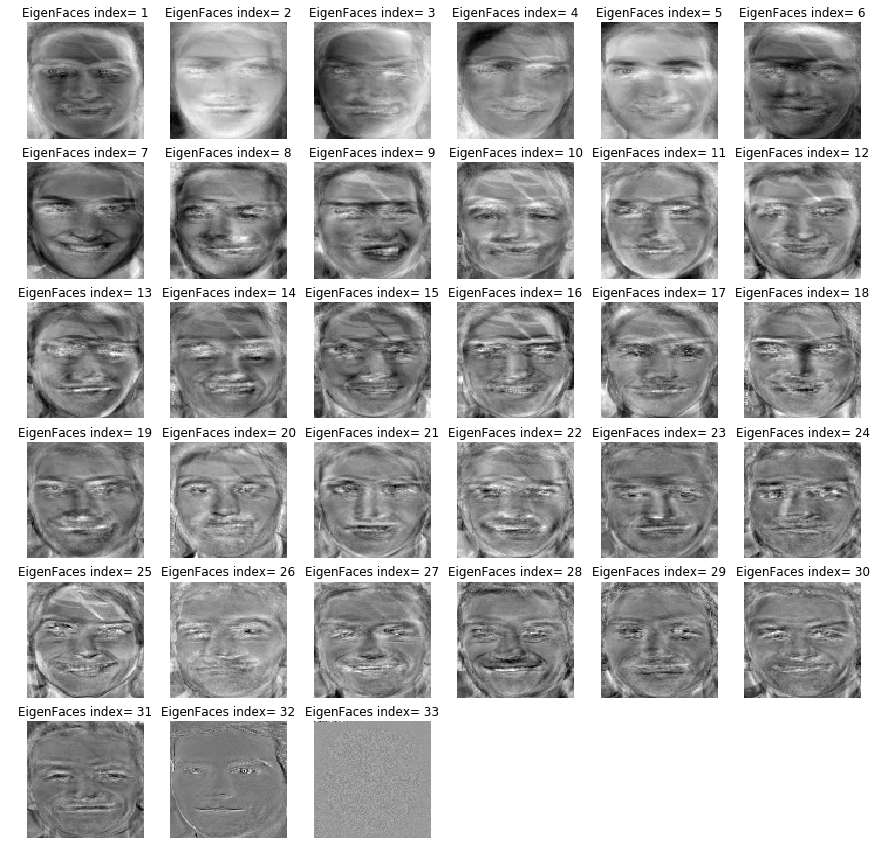

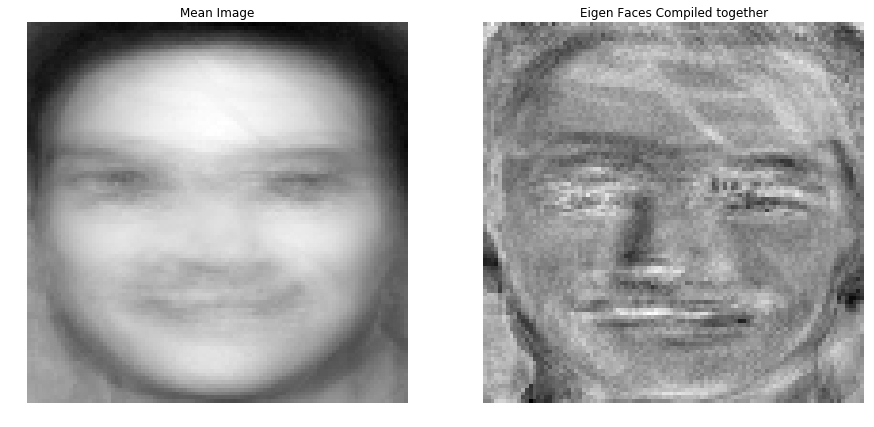

In [5]:
### put the images in rows instead of columns 
D_row = D.transpose()

# initalize the PCA object, with n components = 33 since we have 33 images 
n_components = 33
pca = PCA(n_components=n_components)

# fit the trainning data and center it beforehand
train_img = pca.fit_transform(D_row)

eig_vectors = pca.components_
print(eig_vectors.shape)
temp = eig_vectors.reshape((n_components, 100, 100))
print(temp[0].shape)

# calculate the mean of the data and display the mean face
mean = pca.mean_
meanface = mean.reshape(size)


eig_faces = []
for i in range(n_components):
    eig_faces.append(temp[i])

plt.figure(figsize=(15,15))
for i, eig_face in enumerate(eig_faces):
    plt.subplot(6,6,1+i), plt.imshow(eig_face, cmap='gray')
    plt.title('EigenFaces index= %d' % (i+1)), plt.axis('off')
plt.show()

output = 0
eig_faces = []
for eig_vec in eig_vectors:
    eigface = eig_vec.reshape(size)
    eig_faces.append(eigface)
    output += eigface
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(meanface, cmap='gray')
plt.title('Mean Image'), plt.axis('off')
plt.subplot(122), plt.imshow(output, cmap='gray')
plt.title('Eigen Faces Compiled together'), plt.axis('off')
plt.show()

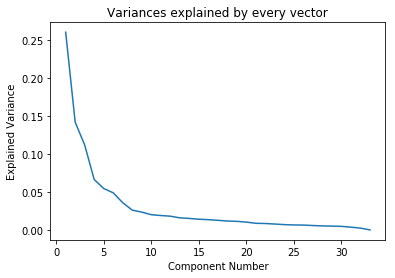

In [6]:
var = pca.explained_variance_ratio_

plt.title('Variances explained by every vector')
plt.plot(range(1, 34), var)
plt.xlabel('Component Number'), plt.ylabel('Explained Variance')
plt.show()

Above is the ratio of the variances explained at each vector. The ratio is a normalized approach which demonstrates the data.

No, not all the points are required to be used. When observing the graph, about most of the graph's big slope occurs from 0-15 and the rest has only marginal changed in its variance there fore the variance does not change much. "The eigenvectors with the largest eigenvalues capture the most variation"

##### Find the matching neighbours for pixel space

In [7]:
# put the image in rows
D_hor = D.transpose()

# create the Nearest neighbours object
nNeigh = NearestNeighbors(n_neighbors=2)
# nbrs = NearestNeighbors(n_neighbors=2).fit(D_hor)

# fit the pixel wise data into the space
nbrs = nNeigh.fit(D_hor)
dist, ind = nbrs.kneighbors(D_hor)

# check to see if image is in its own class
total = ind.shape[0]
matching = []
for i in range(total):
    if ind[i][0] <= 10:
        if ind[i][1] >= 0 and ind[i][1] < 11:
            matching.append(ind[i])
    elif ind[i][0] <= 21:
        if ind[i][1] >= 11 and ind[i][1] < 22:
            matching.append(ind[i])
    elif ind[i][0] <= 32:
        if ind[i][1] >= 22 and ind[i][1] < 33:
            matching.append(ind[i])
            
ref = len(matching)
# calculate the percentage
percent_match = round(ref*10000/total)/100
print('Number of matching neighbours: ' + str(ref))
print('Percentage of matching neighbours: %.2f%%' % percent_match)
# print(dist)
# print(ind)

Number of matching neighbours: 27
Percentage of matching neighbours: 81.82%


##### Calculate the matching neighbours for the eigenspace data

In [8]:
# create the Nearest neighbours object
nNeigh = NearestNeighbors(n_neighbors=2)
# nbrs = NearestNeighbors(n_neighbors=2).fit(D_hor)

# initalize the eigenspace array
eigenspace = np.zeros((D_hor.shape[0], eig_vectors.shape[0]))

#calculate the projections in the eigenspace for training images
for i in range(D_hor.shape[0]):
    for j in range(eig_vectors.shape[0]):
        eigenspace[i][j] = np.dot((D_hor[i]-mean), eig_vectors[j])
        
# fit the pixel wise data into the space
nbrs = nNeigh.fit(eigenspace)

dist_space, ind_space = nbrs.kneighbors(eigenspace)
# print(ind)

# check to see if image is in its own class
total_space = ind_space.shape[0]
matching_space = []
for i in range(total_space):
    if ind_space[i][0] <= 10:
        if ind_space[i][1] >= 0 and ind_space[i][1] < 11:
            matching_space.append(ind_space[i])
    elif ind_space[i][0] <= 21:
        if ind_space[i][1] >= 11 and ind_space[i][1] < 22:
            matching_space.append(ind_space[i])
    elif ind_space[i][0] <= 32:
        if ind_space[i][1] >= 22 and ind_space[i][1] < 33:
            matching_space.append(ind_space[i])
            
ref_space = len(matching_space)
# calculate the percentage
percent_match_space = round(ref_space*10000/total_space)/100
print('Number of matching neighbours: ' + str(ref_space))
print('Percentage of matching neighbours: %.2f%%' % percent_match_space)


# results = []
# eigenfaces = []
# for i, sample in enumerate(D_hor):
#     sample = sample - mean.flatten()
#     eigenface = np.zeros(size).flatten()
#     for eig_vector in eig_vectors:
#         eigenface += np.dot(sample, eig_vector)*eig_vector
#     eigenfaces.append(eigenface)
# eigenfaces = np.asarray(eigenfaces)
# eigenspace = np.subtract(eig_vectors, eigenfaces)

Number of matching neighbours: 27
Percentage of matching neighbours: 81.82%


 If were in the range from 0-10 then the person will be barney, if 11-21 then it will be robin, and if 22-32 then it will be ted
 

## 3 - Face Detection & Identification

In [9]:
# put the images in rows instead of columns 
D_row = D.transpose()

# initalize the PCA object, with less components
n_components = 33
pca_adjust = PCA(n_components=n_components)

# fit the trainning data and center it beforehand
train_new = pca_adjust.fit_transform(D_row)
# new eigenvector and mean
vec_new = pca_adjust.components_
mean_new = pca_adjust.mean_

projection = np.zeros(vec_new.shape[0])

# get group photo in gray
img_gray = cv2.cvtColor(group_img, cv2.COLOR_BGR2GRAY)
# get the dimensions of it to iterate through it
grp_x, grp_y = img_gray.shape
window_size_x = 200
window_size_y = 280
step = 290
# set threshold
threshold = 3100
points = []
# iterate through the whole image
for y in range(0, grp_y-step, 10):
    for x in range(0, grp_x-step, 10):
        temp = 0
        section = img_gray[y:y+window_size_y, x:x+window_size_x]
        patch = cv2.resize(section, size)
        patch = np.reshape(patch, (1, -1))
        for i in range(vec_new.shape[0]):
            projection[i] = np.dot(patch-mean_new, vec_new[i])
            temp += projection[i]*vec_new[i]
        result = np.linalg.norm(patch-(temp+mean_new))
        if int(result) <= threshold:
            points.append(((x,y), result))
            print(((x,y), result))
print(len(points))


((140, 90), 2999.5213537041245)
((150, 90), 3098.805099738141)
((130, 100), 3011.9448352449767)
((140, 100), 2817.059489189453)
((150, 100), 2759.0273141358703)
((160, 100), 2968.54465485652)
((120, 110), 3046.172789370717)
((130, 110), 2709.8752477814965)
((140, 110), 2517.054722180536)
((150, 110), 2555.6877396153154)
((160, 110), 2778.040723807573)
((120, 120), 2958.3583952485196)
((130, 120), 2557.492524111244)
((140, 120), 2392.988239498543)
((150, 120), 2415.381942358932)
((160, 120), 2718.9753355042926)
((170, 120), 3055.6117844667697)
((120, 130), 3049.917364969248)
((130, 130), 2689.3591264705246)
((140, 130), 2561.8489895242683)
((150, 130), 2502.0708963048282)
((160, 130), 2805.2817258056784)
((120, 140), 3085.801111376994)
((130, 140), 2827.318093991849)
((140, 140), 2650.718153366668)
((150, 140), 2642.1372112619956)
((160, 140), 2883.021457753971)
((130, 150), 3040.8463453518953)
((140, 150), 2888.950621682663)
((150, 150), 2893.0504583662228)
((860, 210), 3027.4089809021

[((140, 120), 2392.988239498543), ((870, 220), 2988.4079877467498), ((530, 280), 2623.3735897647016)]
3


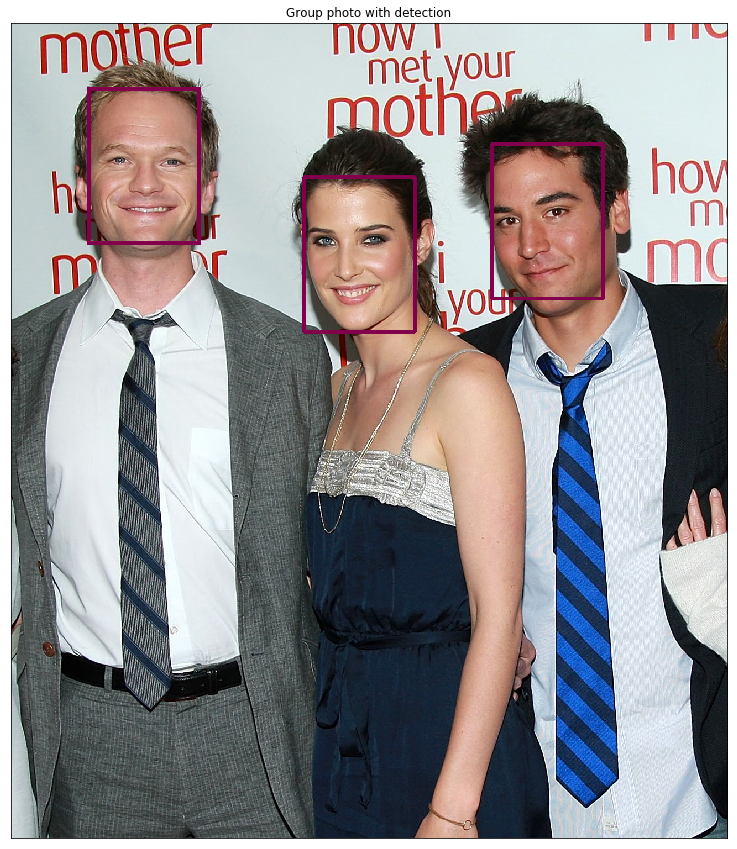

In [11]:
# delete duplicate data for nearby faces
final_pts = [points[0]]

# flag to avoid duplicated in adding into the list
flag = False

for point in points:
    for i, final_pt in enumerate(final_pts):
        diff_x = point[0][0]-final_pt[0][0]
        diff_y = point[0][1]-final_pt[0][1]
        if (diff_x <= 40 and diff_x >= -40) and (diff_y <= 40 and diff_y >= -40):
            flag = True
            if final_pt[1] > point[1]:
                final_pts[i] = point 
    if not flag:
        final_pts.append(point)
    flag = False          
            
print(final_pts)
print(len(final_pts))

for final_pt in final_pts:
    x, y = final_pt[0]
    cv2.rectangle(group_img, (x,y), (x+window_size_x, y+window_size_y), (75,0,130), 5)
    roi_gray = img_gray[y:y+window_size_y, x:x+window_size_x]
    roi_color = group_img[y:y+window_size_y, x:x+window_size_x]

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(group_img, cv2.COLOR_BGR2RGB))
plt.title('Group photo with detection'), plt.xticks([]), plt.yticks([])
plt.show()


        

Number of neighbours checkeed before correct label for NPH: 1
Number of neighbours checkeed before correct label for TM: 1
Number of neighbours checkeed before correct label for CS: 1


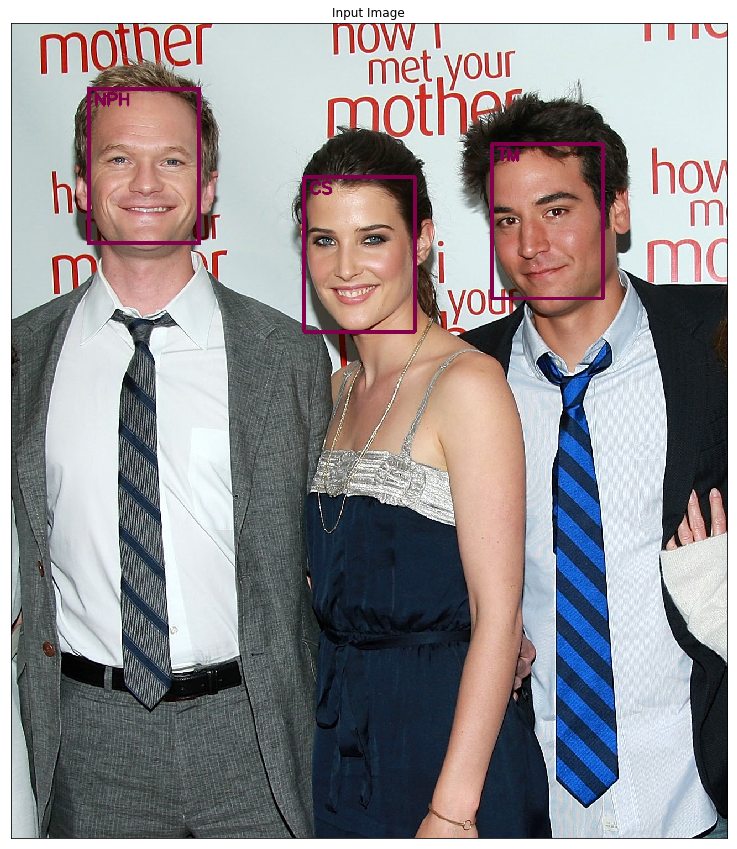

In [12]:
names = ['NPH', 'CS', 'TM']
labels = []
# 0 = nph, 1 = cs, 2 = tm
# label the data
for i in range(33):
    if(i<11):
        labels.append(names[0])
    elif(i<22):
        labels.append(names[1])
    elif(i<33):
        labels.append(names[2])

# get the eigenspace value from the data
eigenspace_new = pca_adjust.transform(D_row)

# copy the previous image in order to overlay text
id_img = group_img.copy()

# get the patches form the points
windows = []
for final_pt in final_pts:
    x, y = final_pt[0]
    section = img_gray[y:y+window_size_y, x:x+window_size_x]
    patch = cv2.resize(section, size)
    windows.append(patch.reshape(1,-1))

# this list contains the class that should have been recognized. 
poss_lbs = []
poss_lbs.append('NPH')
poss_lbs.append('TM')
poss_lbs.append('CS')

# identify who we are looking for
matches = []
attempts = []
for i, face in enumerate(windows):
    SSD = []
    index = []
    
    #compute the weight vectors of the face 
    weight_face = pca.transform(face) 
    
    # compute the SSD for every point
    for j in range(len(eigenspace_new)):
        eig_space = eigenspace_new[j]
        diff = (weight_face-eig_space)**2
        SSD.append(np.sqrt(np.sum(diff, axis = 1)))

        index.append(j)
    
    ssd_min = SSD.index(min(SSD))
    img_min = index[ssd_min]
    total = 1;
    
    while(labels[img_min] != poss_lbs[i]): 
        SSD.pop(ssd_min)
        index.pop(ssd_min)
        ssd_min = SSD.index(min(SSD))
        img_min = index[ssd_min]
        total += 1
    
    matches.append((i, labels[ssd_min]))
    attempts.append(total)

# print out the number of attempts to identify each person with their neighbour
for i in range(len(poss_lbs)):
    print('Number of neighbours checkeed before correct label for {name}: {total}'.format(name=poss_lbs[i], total=attempts[i]))
font = 0

# write the text and display the image
for match in matches:
    x, y = final_pts[match[0]][0]
    cv2.putText(id_img, match[1], (x+10, y+30), font, 1, (75,0,130), 3, cv2.LINE_AA)
    
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(id_img, cv2.COLOR_BGR2RGB))
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.show()


    

From my image detection there weren't any false positives detected. There were only multiple detections that occured on a single face which was eliminated by taking the one with the best result. Therefore, I believe my algorithm for detection is quite accurate ad it was able to identify all three faces without false positives. This was done through modifications to the window size and other factors in order to get the image.

However, I do not believe that it is a robust algorithm as it was tailored in particular for this image by playing with the window size that I used to scan through the image. If there was a new image with different sizes for the faces due to zoom or any other factors, then it is possible that not all faces are detected. In addition if the faces were were tilted or the eyes are not lined up, then the algorithm will struggle to deal with changes in orientation. This would be improved by potentially using a swift method to match keypoints and morph the image to be level. Since Robin has long hair, in some of the training images it is blocking part of her face and this can be a factor in why she was tougher to be identified.



## 4 - Viola-Jones Comparison


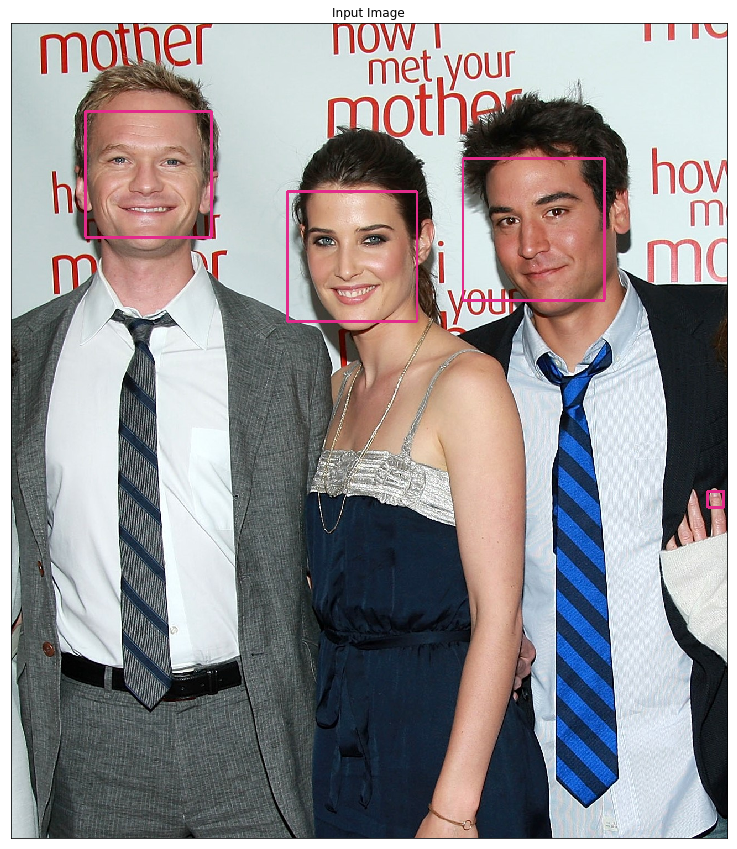

In [13]:
grey_group = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#  get all the dat a compiled together
# Get OpenCV datapath
data_path = cv2.data.haarcascades
face_cascade = cv2.CascadeClassifier( os.path.join(data_path, 'haarcascade_frontalface_default.xml'))

# detect faces
# detectMultiScape(image, scaleFactor, minNeighbors)
# scaleFactor - parameter specifying how much the image size is reduced
#  at each image scale
# minNeighbors - parameter specifying how many neighbors each candidate
#  rectangle should have to retain
faces = face_cascade.detectMultiScale(grey_group, 1.3, 2)
for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (138,43,226), 4)
    roi_gray_ = grey_group[y:y+h, x:x+w]
    roi_color_ = img[y:y+h, x:x+w]

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.show()

Orginally at a lower scale factor (1.1) I had two false positives but as I played with the value and increased it up to 1.3 then I was able to eliminate the false positives. However, when it was increased a lot there were more than 1 detector on the faces.

Viola-Jones if is an invariant detector of scale therefore it is able ot handle images of different scales well. On ther other hand PCA is sensitive to scale in which another scale for normalization is required. In images where the scale of faces have been altered then the Viola-Jones detector has a better ability to work compared to PCA